In [1]:
%matplotlib inline
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
def airmass_calc(altitude, degrees=False):
    altRad = np.radians(altitude) if degrees else altitude
    return 1.0/np.sqrt(1.0-0.96*(np.sin(0.5*np.pi-altRad))**2)
    
def FWHMatm(rawSeeing, band, airmass):
    wl = dict(u=365.49, g=480.03, r=622.20, i=754.06, z=868.21, y=991.66)[band]
    return rawSeeing*(wl/500)**(-0.3)*airmass**(0.6)

def FWHMsys(airmass):
    return 0.4*airmass**(0.6)

def FWHMgeom(rawSeeing, band, airmass):
    FWHMeff = 1.16*np.sqrt(FWHMsys(airmass)**2 + 1.04*FWHMatm(rawSeeing, band, airmass)**2)
    return 0.822*FWHMeff + 0.052

In [3]:
# Values from phosim_cat_197356.txt, Run1.2p.
rawSeeing = 0.5059960
band = 'r'
altitude = 52.54199126195116065
FWHMgeom_value = 0.7343130
print(FWHMgeom(rawSeeing, band, airmass_calc(altitude, degrees=True)))

0.7342932719


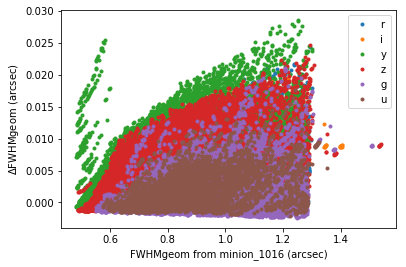

In [6]:
# Check against values from an opsimdb file.
opsim_db = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
conn = sqlite3.connect(opsim_db)
nrows = 100000
query = 'select rawSeeing, filter, altitude, FWHMgeom from Summary limit {}'.format(nrows)
#print(query)
cursor = conn.cursor()
cursor.execute(query)
FWHMgeom_calc = np.zeros(nrows, dtype=float)
FWHMgeom_db = np.zeros(nrows, dtype=float)
bands = np.array(['']*nrows)
for i, entry in enumerate(cursor):
    rawSeeing, band, altitude, fwhm_geom = entry
    FWHMgeom_calc[i] = FWHMgeom(rawSeeing, band, airmass_calc(altitude))
    FWHMgeom_db[i] = fwhm_geom
    bands[i] = band
    
for band in set(bands):
    index = np.where(bands==band)
    _ = plt.errorbar(FWHMgeom_db[index], FWHMgeom_db[index] - FWHMgeom_calc[index],
                     fmt='.', label=band)
plt.legend(loc=0)
#plt.ylim(-0.2, 0.2)
_ = plt.xlabel('FWHMgeom from minion_1016 (arcsec)')
_ = plt.ylabel(r'$\Delta$FWHMgeom (arcsec)')
#print(min(FWHMgeom_db), max(FWHMgeom_db), min(FWHMgeom_calc), max(FWHMgeom_calc))
plt.savefig('FWHMgeom_calculations.png')

In [5]:
airmass_calc(52.542, degrees=True)

1.2452298413017844